# Deep Reinforcement Learning Project: BananaHunter Notebook

---

This notebook shows how to use the Unity ML-Agents environment to train an agent to collect yellow bananas simultaneously avoiding blue bananas using Deep Reinforcement Learning.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit *Prequisited and Installation* Section in the [README](https://github.com/sebastian-kleinschmidt/RL_BananaHunter/REAMDME.md).

In [1]:
from unityagents import UnityEnvironment
from agent import Agent
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="simulation/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


### 4. Train an Agent from Scratch

The following cells will reset the environment and initialize and train an agent to collect yellow bananas and avoid blue bananas.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size, seed=0)

### 4.1 Learning Algorithm
The learning algorithm uses Deep-Q-Learning. For a total of *n_episodes* the agents choses an *action* based on the current *state* and collects the *subsequent state/next_state* and the *reward* as result of his previous chosen action.

With the state, action, reward and next_state information, the agent adds these information to the replay buffer using the step function, which is implemented in agent class defined in the agent.py. Each 4 steps (defined in the UPDATE_EVERY variable of the class), the agent starts learning, as long as we have enough data in our replay buffer available. We then uniformly sample from the replay buffer 64 tuples.

Using the states of the sampled experiences form the replay buffer, a forward pass using the **target neural network** define in the model.py (see description in Section 4.3) for the *next_state* and the action, which would maximize the reward, is performed. Together with the discount rate gamma and the reward for the transition, we compute t_target. Together with the current predictions Q_expected, we can build up out cost function an optimize the network (element-wise mean squared error of Q_expected and Q_targets).

If the mean score for the last 100 episodes is above the goal of 13, the current model is saved. It would also be possible to stop the training here, but for visualize how good the model can perform with the maximum number of episodes (determinde by n_episodes), the training continues after reaching the goal.

In [7]:
def dqn(n_episodes=2000, max_t=9999, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    prev_best_score_window = 0
    best_score_window = 0
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            if prev_best_score_window!=best_score_window:
                prev_best_score_window=best_score_window
                print('\rEpisode {}\tAverage Score: {:.2f} - Better Solution found!'.format(i_episode, best_score_window))
            else:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and np.mean(scores_window)>best_score_window:
            if best_score_window==0:
                print('\nEnvironment solved the first time in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            best_score_window = np.mean(scores_window)
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

### 4.2 Hyperparameters

In [8]:
# Define Hyperparameters
n_episodes=2000
max_t=99999
eps_start=1.0
eps_end=0.01
eps_decay=0.995

# Start training
scores = dqn(n_episodes, max_t, eps_start, eps_end, eps_decay)

Episode 100	Average Score: 1.00
Episode 200	Average Score: 4.87
Episode 300	Average Score: 8.02
Episode 400	Average Score: 9.86
Episode 500	Average Score: 12.72
Episode 535	Average Score: 13.04
Environment solved the first time in 435 episodes!	Average Score: 13.04
Episode 600	Average Score: 13.55 - Better Solution found!
Episode 700	Average Score: 14.40 - Better Solution found!
Episode 800	Average Score: 14.95 - Better Solution found!
Episode 900	Average Score: 16.05 - Better Solution found!
Episode 1000	Average Score: 16.19 - Better Solution found!
Episode 1100	Average Score: 14.93
Episode 1200	Average Score: 15.13
Episode 1300	Average Score: 15.51
Episode 1400	Average Score: 15.70
Episode 1500	Average Score: 16.22 - Better Solution found!
Episode 1600	Average Score: 16.26 - Better Solution found!
Episode 1700	Average Score: 17.18 - Better Solution found!
Episode 1800	Average Score: 15.62
Episode 1900	Average Score: 15.60
Episode 2000	Average Score: 15.03


**Hyperparameter Definition:**
- **n_episodes** - *maximum number of training episodes*<br> According to Section 4.3 *2000* is high enough to archieve the goal of the task but might be to high achieving no significant improvement in the second half after approx episode 600.
- **max_t** -  *maximum number of timesteps per episode*
With a maximum number of timesteps per episode of 99999, each episode should run until it's end.
- **eps_start** - *starting value of epsilon, for epsilon-greedy action selection*
Epsilon-greedy starts with a value of 1.0 for selecting random actions at first and concentrate on exploration.
- **eps_end** - *minimum value of epsilon*
Epsilon-greedy starts with a value of 0.1 for using the trained and model (exploiting) and only little roomf or exploration.
- **eps_decay** - *multiplicative factor (per episode) for decreasing epsilon*
The decay between both values i 0.995 per episode.

### 4.3 Model Architecture
The architecture of the model is defined in the model.py file. The network is a three linear-layer network with an input size of 37 (according to the number of states), 64 hidden units in the second layer and an output dimension of 4 of the output layer (according to the number of actions). Rectified Linear Unit (ReLU) are used as activation functions for the first and second layer.

### 4.4 Plot of Rewards per Episode
Subsequently you can see a plot of the score over the number of episodes:

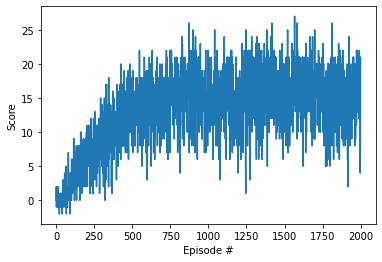

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

According to the printed output during training and visualization of the plot, the network was able to solve the task (average reward (over 100 episodes) of at least +13) after episode 452. From this point on, the model further improved until approx. episode xx. Therefore, a reduction of the hyperparameter *n_episodes* seems to be reasonable to episode 750.

### 4.5 Ideas for Future Work
- **More sophisticated network architecture**
The used network is a very shallow network. A deeper and more sophisticated network might perform better.
- **Implement Double Q-Learning**
Traditional Deep Q-Learning as used in this implementation tends to overestimates the action values. A possible extension would therefore to use Double Q-Learning.
- **Priorized Experience Replay**
The implementation samples experience transistions uniformly from the replay buffer. Important transitions can be sampled with higher probabilities using *Priorized Experience Replay* to learn more effectively.
- **Dueling DQN**
By replacing the tradition Deep-Q-Network with a dueling architecutre, the values of each state can be assessed without having to learn the effect of each action.

### 5. Demonstrate Trained Agent
Now let's load the best performing model and let us see, how it performs.

In [10]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)        # select an action
    env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


### 6. Shutdown Environment
Last thing to do is to shut down the environment

In [11]:
env.close()